In [2]:
!gdown 1N193DSAgGZgcKuT1LDY9iszV0DV74uC2

Downloading...
From: https://drive.google.com/uc?id=1N193DSAgGZgcKuT1LDY9iszV0DV74uC2
To: /content/FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 99.4MB/s]


In [3]:
!unzip /content/FruitinAmazon.zip

Archive:  /content/FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmazon/train

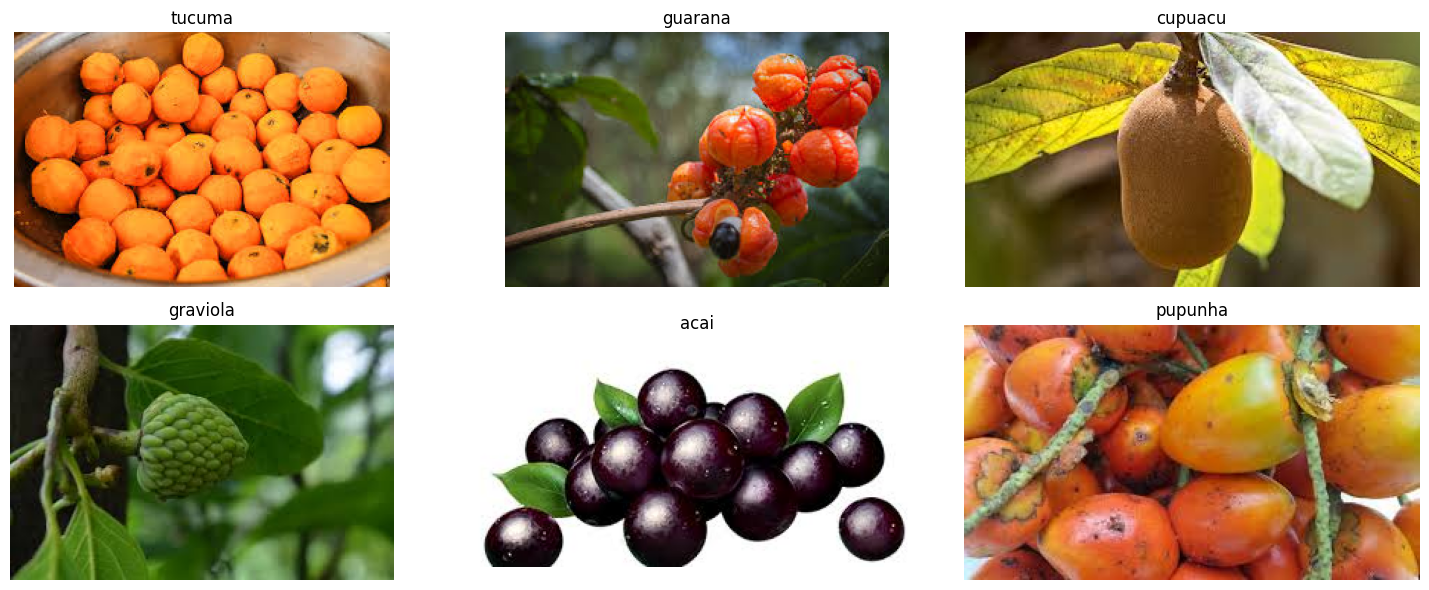

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image

train_dir = "/content/FruitinAmazon/train"
test_dir = "/content/FruitinAmazon/test"

img_height, img_width = 28, 28

def load_and_visualize_images(train_dir, num_rows=2):
  class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

  selected_images = []
  labels = []
  for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
    if images:
      selected_image = random.choice(images)
      selected_images.append(os.path.join(class_path, selected_image))
      labels.append(class_dir)

  num_cols = (len(selected_images) + num_rows - 1) // num_rows

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
  axes = axes.flatten()

  for i, img_path in enumerate(selected_images):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(labels[i])
    axes[i].axis('off')

  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.show()

load_and_visualize_images(train_dir)

In [5]:
def check_corrupted_images(train_dir):
  corrupted_images = []

  for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    if os.path.isdir(class_path):
      for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        try:
          with Image.open(image_path) as img:
            img.verify()
        except (IOError, SyntaxError):
          corrupted_images.append(image_path)
          os.remove(image_path)
          print(f'Removed corrupted image: {image_path}')
  if not corrupted_images:
    print('No corrupted images found.')

check_corrupted_images(train_dir)

No corrupted images found.


In [6]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset="training",
    seed=123
)

class_names = train_ds.class_names

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [7]:
print(class_names)
num_class = len(class_names)

print("Number of classes:", num_class)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=1, input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax')
])

model.summary()

['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('mymodel.h5', save_best_only=True, monitor='val_loss')
earlyStoping_cb = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    callbacks=[checkpoint_cb, earlyStoping_cb]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.0694 - loss: 1.9448

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.0729 - loss: 1.9614 - val_accuracy: 0.1667 - val_loss: 1.6891
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.2127 - loss: 1.8150 - val_accuracy: 0.2778 - val_loss: 1.7147
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.2188 - loss: 1.6553

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 856ms/step - accuracy: 0.2266 - loss: 1.6512 - val_accuracy: 0.5000 - val_loss: 1.6330
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6580 - loss: 1.4694

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.6393 - loss: 1.4633 - val_accuracy: 0.5000 - val_loss: 1.5574
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5388 - loss: 1.3043

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.5464 - loss: 1.2998 - val_accuracy: 0.7778 - val_loss: 1.0123
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.6593 - loss: 1.0513 - val_accuracy: 0.7222 - val_loss: 1.2111
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.7695 - loss: 0.8857 - val_accuracy: 0.4444 - val_loss: 1.2922
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7905 - loss: 0.6855

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 831ms/step - accuracy: 0.7873 - loss: 0.6846 - val_accuracy: 0.8889 - val_loss: 0.5473
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.7891 - loss: 0.5747 - val_accuracy: 0.8333 - val_loss: 0.6711
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.9488 - loss: 0.3942 - val_accuracy: 0.5556 - val_loss: 1.3118
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.8947 - loss: 0.4899

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 954ms/step - accuracy: 0.8967 - loss: 0.4799 - val_accuracy: 0.8333 - val_loss: 0.5393
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.9891 - loss: 0.2276 - val_accuracy: 0.8889 - val_loss: 0.6602
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8547 - loss: 0.3644

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.8563 - loss: 0.3577 - val_accuracy: 0.8889 - val_loss: 0.3166
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - accuracy: 0.9813 - loss: 0.1098 - val_accuracy: 0.7222 - val_loss: 0.5945
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.9596 - loss: 0.1590 - val_accuracy: 0.8333 - val_loss: 0.3881
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9797 - loss: 0.0870

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step - accuracy: 0.9813 - loss: 0.0856 - val_accuracy: 0.9444 - val_loss: 0.2211
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9601 - loss: 0.1117

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.9596 - loss: 0.1110 - val_accuracy: 0.9444 - val_loss: 0.1626
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 1.0000 - loss: 0.0353 - val_accuracy: 0.7222 - val_loss: 0.4413
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 1.0000 - loss: 0.0356 - val_accuracy: 0.8333 - val_loss: 0.4593
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.8333 - val_loss: 0.4713
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.8333 - val_loss: 0.4286


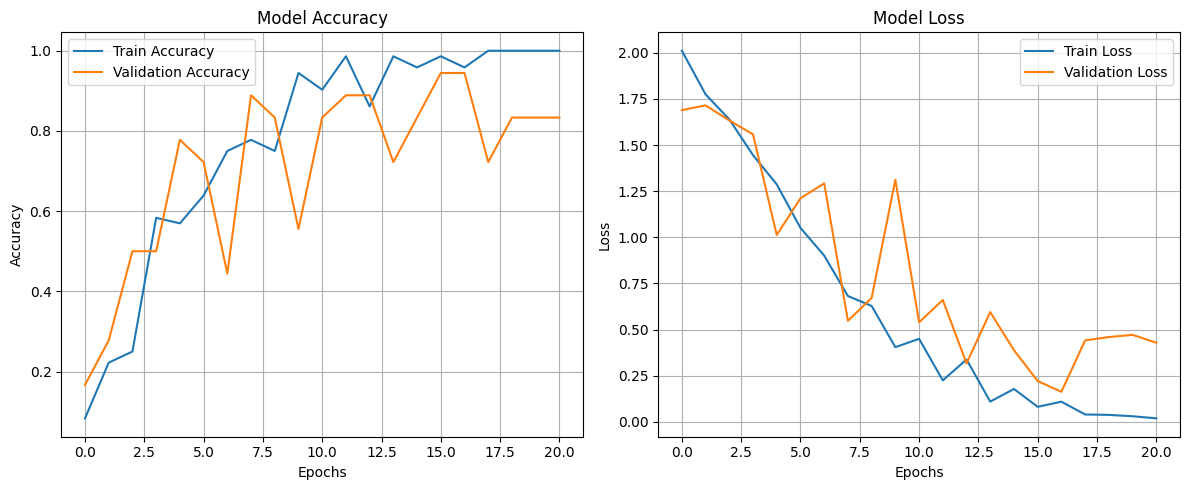

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size = batch_size,
    shuffle=False
)

class_names = test_ds.class_names

test_ds = test_ds.map(lambda x, y: (rescale(x), y))

loss, accuracy=model.evaluate(test_ds)

print(f'Test Accuracy: {accuracy: .4f}, Test Loss: {loss: .4f}')

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7333 - loss: 0.6731
Test Accuracy:  0.7333, Test Loss:  0.6731


In [21]:
model.save('final_fruit_model.h5')

loaded_model = tf.keras.models.load_model('final_fruit_model.h5')

loaded_model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.7333 - loss: 0.6731


[0.6730809807777405, 0.7333333492279053]

In [23]:
from sklearn.metrics import classification_report

y_true = []
for _, labels in test_ds:
  y_true.extend((labels.numpy()))
y_true = np.array(y_true)

if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
              precision    recall  f1-score   support

        acai       0.50      1.00      0.67         5
     cupuacu       1.00      0.80      0.89         5
    graviola       0.80      0.80      0.80         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.83      1.00      0.91         5
      tucuma       0.67      0.40      0.50         5

    accuracy                           0.73        30
   macro avg       0.80      0.73      0.72        30
weighted avg       0.80      0.73      0.72        30

